# Time series analysis on the data International Airline Passengers from 1949 to 1960

In [29]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# remove warnings
import warnings
warnings.filterwarnings('ignore')

In [8]:
# data fetch 
df = pd.read_csv("AirPassengers.csv")
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


<Axes: xlabel='Month'>

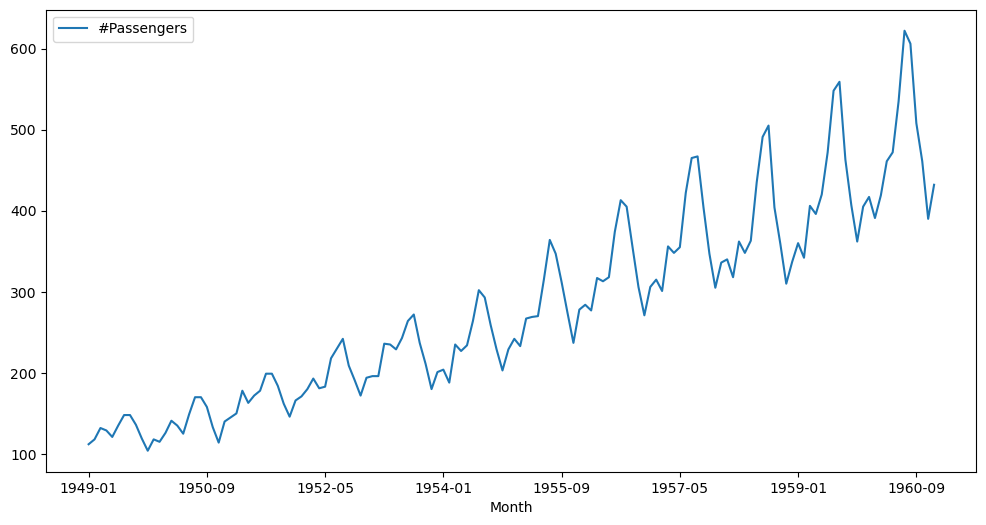

In [ ]:
# Plot this data to see trends and seasonality 
df.plot(x='Month' , y='#Passengers' , figsize=(12,6))

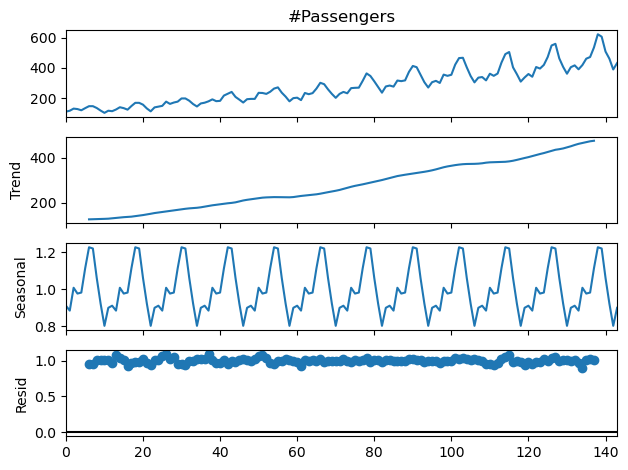

In [19]:
# decompose the data
decomposition = seasonal_decompose(df['#Passengers'], model='multiplicative', period=12)
fig = decomposition.plot()
plt.show()

In [21]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

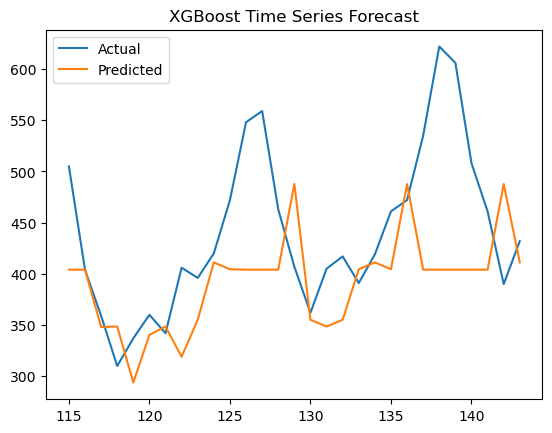

In [24]:

import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Assume df is already loaded and has a datetime index
# and "#Passengers" as the target column

# Create lag feature(s)
df['lag1'] = df['#Passengers'].shift(1)

# Drop NaN values created by shifting
df.dropna(inplace=True)

# Split into train and test
train_size = int(len(df) * 0.8)
train = df[:train_size]
test = df[train_size:]

# Prepare training and testing data
X_train = train[['lag1']]
y_train = train['#Passengers']
X_test = test[['lag1']]
y_test = test['#Passengers']

# Train XGBRegressor
model = XGBRegressor(n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Plot actual vs predicted
plt.plot(test.index, y_test, label="Actual")
plt.plot(test.index, predictions, label="Predicted")
plt.legend()
plt.title("XGBoost Time Series Forecast")
plt.show()


In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Evaluation metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

# Print results
print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")


MAE:  65.90
MSE:  7683.18
RMSE: 87.65
R²:   -0.2586


-----------------------

MAE:  53.45
MSE:  4325.63
RMSE: 65.77
R²:   0.3190


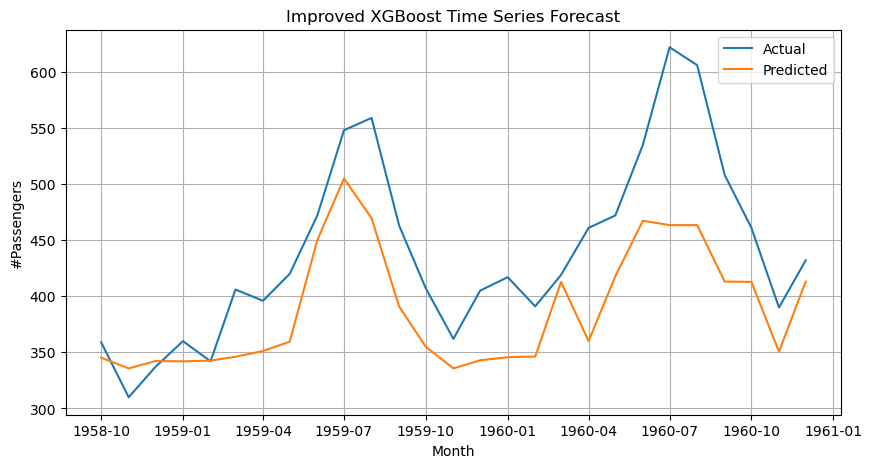

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Step 1: Load full AirPassengers dataset
df = pd.read_csv("AirPassengers.csv")  # Or load manually
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

# Step 2: Feature engineering
# Lag features (up to 12 months)
for i in range(1, 13):
    df[f'lag{i}'] = df['#Passengers'].shift(i)

# Time-based features
df['month'] = df.index.month
df['year'] = df.index.year

# Rolling average
df['rolling_mean_3'] = df['#Passengers'].rolling(window=3).mean()

# Drop NaN rows created by shifts/rolling
df.dropna(inplace=True)

# Step 3: Train-test split (80%)
train_size = int(len(df) * 0.8)
train = df[:train_size]
test = df[train_size:]

# Define features and target
features = [col for col in df.columns if col != '#Passengers']
X_train = train[features]
y_train = train['#Passengers']
X_test = test[features]
y_test = test['#Passengers']

# Step 4: Train XGBoost model
model = XGBRegressor(n_estimators=200, learning_rate=0.1)
model.fit(X_train, y_train)

# Step 5: Predict and evaluate
predictions = model.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")

# Step 6: Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(test.index, y_test, label="Actual")
plt.plot(test.index, predictions, label="Predicted")
plt.title("Improved XGBoost Time Series Forecast")
plt.xlabel("Month")
plt.ylabel("#Passengers")
plt.legend()
plt.grid(True)
plt.show()


1/1 [==============================] - 0s 64ms/step
MAE:  16.72
MSE:  439.60
RMSE: 20.97
R²:   0.9308


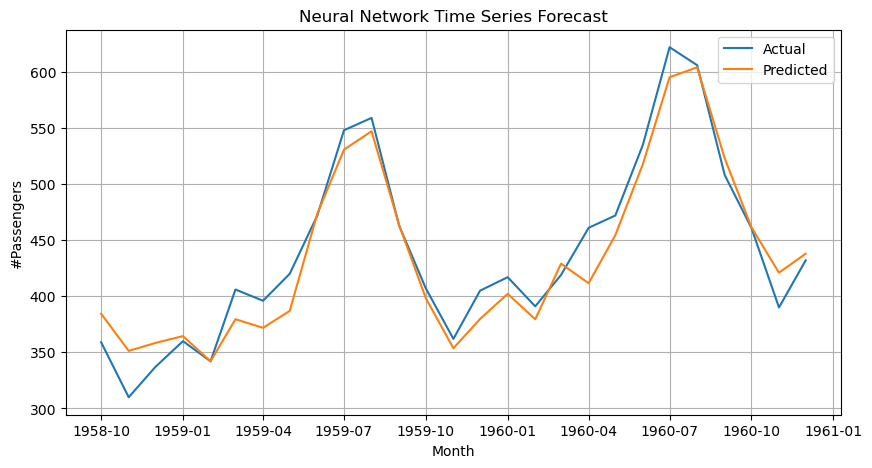

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Step 1: Load dataset
df = pd.read_csv("AirPassengers.csv")  # Ensure this file exists
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

# Step 2: Create lag features
for i in range(1, 13):
    df[f'lag{i}'] = df['#Passengers'].shift(i)

df.dropna(inplace=True)

# Step 3: Normalize features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)

# Step 4: Train-test split
train_size = int(len(scaled) * 0.8)
train = scaled[:train_size]
test = scaled[train_size:]

X_train = train[:, 1:]  # all lag features
y_train = train[:, 0]   # target: #Passengers
X_test = test[:, 1:]
y_test = test[:, 0]

# Step 5: Build neural network
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Output layer

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=200, verbose=0)

# Step 6: Predictions and inverse transform
y_pred_scaled = model.predict(X_test).flatten()
# Rebuild a DataFrame to inverse scale only #Passengers column
y_pred = scaler.inverse_transform(np.hstack([y_pred_scaled.reshape(-1, 1), X_test]))[:, 0]
y_true = scaler.inverse_transform(np.hstack([y_test.reshape(-1, 1), X_test]))[:, 0]

# Step 7: Evaluation
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")

# Step 8: Plot
plt.figure(figsize=(10, 5))
dates = df.index[train_size:]
plt.plot(dates, y_true, label="Actual")
plt.plot(dates, y_pred, label="Predicted")
plt.title("Neural Network Time Series Forecast")
plt.xlabel("Month")
plt.ylabel("#Passengers")
plt.legend()
plt.grid(True)
plt.show()
